In [1]:
import os
from IPython.display import clear_output
os.chdir("./drive/My Drive/Colab Notebooks/SDSProject/MyProject")
os.getcwd()
#os.listdir(".")

'/content/drive/My Drive/Colab Notebooks/SDSProject/MyProject'

In [0]:
%tensorflow_version 1.x
!pip install Scikit-learn==0.19.1
clear_output()

In [3]:
import numpy as np
import imageio
import time, os, math, re, random, io, collections
import pandas as pd
import matplotlib.pyplot as plt
import keras
from itertools import chain
from keras.models import Model
from keras.utils import np_utils
from keras import regularizers
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [0]:
def getExpertiseLevelOfSurgery(surgery_name):
	## function getMetaDataForSurgeries should be already called
	if surgeries_metadata.__contains__(surgery_name):
		return surgeries_metadata[surgery_name][0]
	return None 

def getMetaDataForSurgeries(surgery_type):
	surgeries_metadata = {}
	file = open(root_dir+surgery_type+'/'+'meta_file_'+surgery_type+'.txt','r')
	for line in file: 
		line = line.strip() ## remove spaces
	
		if len(line)==0: ## if end of file
			break
	
		b = line.split()
		surgery_name = b[0] 
		expertise_level = b[1]
		b = b[2:]
		scores = [int(e) for e in b]
		surgeries_metadata[surgery_name]=(expertise_level,scores)
	return surgeries_metadata

def fit_encoder(y_train,y_test,y_val): 
	y_train_test_val = y_train+y_test+y_val
	encoder.fit(y_train_test_val)

def convertStringClassesToBinaryClasses(y_train,y_test,y_val):
	idx_y_test = len(y_train)
	idx_y_val = len(y_train)+len(y_test)
	y_train_test_val = y_train+y_test+y_val
	y_train_test_val = encoder.transform(y_train_test_val)
	y_train_test_val = np_utils.to_categorical(y_train_test_val)
	y_train = y_train_test_val[0:idx_y_test]
	y_test = y_train_test_val[idx_y_test:idx_y_val]
	y_val = y_train_test_val[idx_y_val:]
	return y_train,y_test,y_val

def get_trial_num(surgery_name,surgery_type):
	trial_num = surgery_name.replace(surgery_type+'_',"")[-1]
	return trial_num

def readFile(file_name,dtype,columns_to_use=None):
	X = np.loadtxt(file_name,dtype,usecols=columns_to_use)
	return X

def generateMaps(surgery_type):
	listOfSurgeries =[]
	y =[]
	path = root_dir+surgery_type+'/kinematics/AllGestures/'
	for subdir,dirs,files in os.walk(path):
		for file_name in files: 
			surgery = readFile(path+file_name,float,columns_to_use=dimensions_to_use)
			surgery_name = file_name[:-4]
			expertise_level = getExpertiseLevelOfSurgery(surgery_name)
			if expertise_level is None: 
				continue
			mapSurgeryDataBySurgeryName[surgery_name] = surgery
			mapExpertiseLevelBySurgeryName[surgery_name] = expertise_level
	return None


def write_csv_string_in_file(file_name,csv_string):
	file = open(path_to_results+ file_name + '.csv','w')
	file.write(csv_string)
	file.close()
	return True

# shuffles train and labels 
def shuffle(x_train,y_train):
	y_train = np.array(y_train)
	y_train = y_train.reshape(len(y_train),1)
	x_train = x_train.reshape(len(x_train),1)
	x_y_train = np.concatenate((x_train,y_train), axis=1)
	np.random.shuffle(x_y_train)
	return x_y_train[:,0] , x_y_train[:,1].tolist()

#-------------------------------------------------------#
#---------------User out validation---------------------#
#-------------------------------------------------------#
def validation(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=20):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
  #UserOut & SuperTrialOut
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'UserOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_name_letter(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'UserOut'+'/.*_Out').replace('UserOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	
					
				model = load_model('LOUO/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	return write_csv_string_in_file(results_file_name,results)

 
#-------------------------------------------------------#
#---------------User out validation with curve----------#
#-------------------------------------------------------#
def validation_curve(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=20):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
  #UserOut & SuperTrialOut
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'UserOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_name_letter(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'UserOut'+'/.*_Out').replace('UserOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				#y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	

				
				y_test, curve_acc, curve_loss = fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val)	
				#print(curve_acc)
				
				plt.plot(curve_acc[0], color = 'g', label='train')
				plt.plot(curve_acc[1], color = 'blue', label='val')
				plt.legend()
				plt.xlabel('epochs')
				plt.ylabel('acc')
				plt.title("ACC curve")
				plt.show()

				plt.plot( curve_loss[0], color = 'g', label='train')
				plt.plot( curve_loss[1], color = 'blue', label='val')
				plt.legend()
				plt.xlabel('epochs')
				plt.ylabel('loss')
				plt.title("LOSS curve")
				plt.show()

				model = load_model('LOUO/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	return write_csv_string_in_file(results_file_name,results)


def find_pattern(word,pattern):
	return re.search(r''+pattern,word).group(0)

def compute_micro(matrix):
	return sum(matrix.diagonal()) / np.sum(matrix)

def compute_macro(matrix):
	res = matrix.diagonal()/np.sum(matrix,axis=1)
	return np.nansum(res)/float(nb_classes)

def fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	# train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss = 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_val_loss = evaluate_for_epoch(model,x_val,y_val_binary)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('LOUO/model.h5')
			min_val_loss= epoch_val_loss

	return y_test_binary

def evaluate_for_epoch(model,x_test,y_test):
	epoch_test_loss = 0 
	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		epoch_test_loss += loss ############### change if monitor acc instead of loss
	return epoch_test_loss/len(x_test)

def evaluateModel(model,x_test,y_test):
	confusion_matrix_f = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) 

	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		p = model.predict(split_input_for_training(test), batch_size = 1)
		predicted_integer_label = np.argmax(p).astype(int)
		predicted_label = encoder.inverse_transform(predicted_integer_label)
		correct_label = encoder.inverse_transform(np.argmax(label))
		confusion_matrix[correct_label][predicted_label]+=1.0
		confusion_matrix_f[correct_label][predicted_label]+=1.0

	matrix_f = confusion_matrix_f.to_numpy()
	macro = compute_macro(matrix_f)
	return (macro,compute_micro(matrix_f))

# the sequence variable is the multivariate time series or in this case the surgical task
# we want to split the inputs in order to train  
def split_input_for_training(sequence):
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# define the new input sequence 
	x = []
	# this is used to keep track of the assigned dimensions 
	last = 0
	# loop over each hand 
	for i in range(num_hands):
		# loop for each hand over the cluster of dimensions 
		for j in range(num_dim_clusters): 
			# assign new input same length but different dimensions each time 
			x.append(np.array([sequence[:,last:(last+input_shapes[i][j][1])]]))
			# remember last assigned 
			last= input_shapes[i][j][1]
	# return the new input 
	return x                              

def each_dim_build_model(input_shapes,summary=False, reg=0.00001): 
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# first index for hand second for  dims
	x =[[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# first conv layer on each dim cluster for each hand 
	conv1 = [[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# merged layers for each hand 
	hand_layers =[None for a in range(num_hands)]
	# second conv layer on concatenated conv1 for each hand
	conv2 = [None for a in range(num_hands)] 
	# loop over each hand 
	for i in range(0,num_hands): 
		# loop for each hand over the dimension (or channels) clusters 
		for j in range(0,num_dim_clusters): 
			# input layer for each dimension cluster for each hand 
			x[i][j]=keras.layers.Input(input_shapes[i][j])
			# first conv layer over the clustered dimensions or channels in terms of keras 
			conv1[i][j] = keras.layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activity_regularizer=regularizers.l2(reg))(x[i][j])
			conv1[i][j] = keras.layers.Activation('relu')(conv1[i][j])
		# concatenate convolutions of first layer over the channels dimension for each hand 
		hand_layers[i]=keras.layers.Concatenate(axis=-1)(conv1[i])
		# do a second convolution over features extracted from the first convolution over each hand 
		conv2[i] = keras.layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activity_regularizer=regularizers.l2(reg))(hand_layers[i])
		conv2[i] = keras.layers.Activation('relu')(conv2[i])
	# concatenate the features of the two hands 
	final_input = keras.layers.Concatenate(axis=-1)(conv2) 
	# do a final convolution over the features concatenated for all hands 
	conv3 = keras.layers.Conv1D(32,kernel_size=3,strides=1,padding='same', activity_regularizer = regularizers.l2(reg))(final_input)
	conv3 = keras.layers.Activation('relu', name = "conv_final")(conv3)
	# do a globla average pooling of the final convolution 
	pooled = keras.layers.GlobalAveragePooling1D()(conv3)
	# add the final softmax classifier layer 
	out = keras.layers.Dense(nb_classes,activation='softmax')(pooled)
	# create the model and link input to output 
	model = Model(inputs=list(chain.from_iterable(x)),outputs=out)
	# show summary if specified 
	if summary==True : 
		model.summary()

	# choose the optimizer 
	optimizer = keras.optimizers.Adam()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	return model

def get_name_letter(surgery_name,surgery_type):
	name_letter = surgery_name.replace(surgery_type+'_',"")[-4]
	return name_letter

#for draw figures
def fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	curve_acc = [[],[]]
	curve_loss = [[],[]]
  # train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss, epoch_val_acc, epoch_tra_loss, epoch_tra_acc = 0, 0, 0, 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_tra_loss, epoch_tra_acc = evaluate_for_epoch(model,x_train,y_train_binary)
		epoch_val_loss, epoch_val_acc = evaluate_for_epoch(model,x_val,y_val_binary)
		print("acc : t/v", epoch_tra_acc, epoch_val_acc)
		print("loss: t/v", epoch_tra_loss, epoch_val_loss)
		curve_acc[0].append(epoch_tra_acc)
		curve_acc[1].append(epoch_val_acc)
		curve_loss[0].append(epoch_tra_loss)
		curve_loss[1].append(epoch_val_loss)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('LOUO/model.h5')
			min_val_loss= epoch_val_loss
	return y_test_binary, curve_acc, curve_loss

def evaluate_for_epoch(model,x_test,y_test):
	epoch_test_loss, epoch_test_acc = 0, 0
	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		epoch_test_loss += loss ############### change if monitor acc instead of loss
		epoch_test_acc += acc ############### change if monitor acc instead of loss
	return epoch_test_loss/len(x_test), epoch_test_acc/len(x_test)

In [0]:
#Drop out version
def each_dim_build_model(input_shapes,summary=True, reg=0.00001): 
	# get number of hands 
	num_hands= len(input_shapes)
	print(num_hands)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	print(num_dim_clusters)
  # first index for hand second for  dims
	x =[[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# first conv layer on each dim cluster for each hand 
	conv1 = [[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# merged layers for each hand 
	hand_layers =[None for a in range(num_hands)]
	# second conv layer on concatenated conv1 for each hand
	conv2 = [None for a in range(num_hands)] 
	# loop over each hand 
	for i in range(0,num_hands): 
		# loop for each hand over the dimension (or channels) clusters 
		for j in range(0,num_dim_clusters): 
			# input layer for each dimension cluster for each hand 
			x[i][j]=keras.layers.Input(input_shapes[i][j])
			# first conv layer over the clustered dimensions or channels in terms of keras 
			conv1[i][j] = keras.layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activity_regularizer=regularizers.l2(reg))(x[i][j])
			conv1[i][j] = keras.layers.Activation('relu')(conv1[i][j])
		# concatenate convolutions of first layer over the channels dimension for each hand 
		hand_layers[i]=keras.layers.Concatenate(axis=-1)(conv1[i])
		# do a second convolution over features extracted from the first convolution over each hand 
		conv2[i] = keras.layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activity_regularizer=regularizers.l2(reg))(hand_layers[i])
		conv2[i] = keras.layers.Activation('relu')(conv2[i])
	# concatenate the features of the two hands 
	final_input = keras.layers.Concatenate(axis=-1)(conv2) 
	# do a final convolution over the features concatenated for all hands 
	conv3 = keras.layers.Conv1D(32,kernel_size=3,strides=1,padding='same', activity_regularizer = regularizers.l2(reg))(final_input)
	conv3 = keras.layers.Activation('relu', name = "conv_final")(conv3)

	# do a globla average pooling of the final convolution 
	pooled = keras.layers.GlobalAveragePooling1D()(conv3)
 	#add drop out 
	drop = keras.layers.Dropout(0.5)(pooled)
	print("drop out")
	# add the final softmax classifier layer 
	out = keras.layers.Dense(nb_classes,activation='softmax')(drop)
	# create the model and link input to output 
	model = Model(inputs=list(chain.from_iterable(x)),outputs=out)
	# show summary if specified 
	if summary==True : 
		model.summary()
		print(model.summary())

	# choose the optimizer 
	optimizer = keras.optimizers.Adam()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	return model

Number of different surgeries in total: 39
train size:30
val size:5
test size:4



acc : t/v 0.5 0.0
loss: t/v 0.9304024080435435 1.8006773233413695
acc : t/v 0.7333333333333333 0.0
loss: t/v 0.8228850493828456 1.8815408229827881
acc : t/v 0.6333333333333333 0.0
loss: t/v 0.7231318750729163 2.6162485599517824
acc : t/v 0.7 0.0
loss: t/v 0.6056115232408047 3.184971284866333
acc : t/v 0.8 0.0
loss: t/v 0.512941191966335 2.153299021720886
acc : t/v 0.8 0.0
loss: t/v 0.4118533816188574 4.060446071624756
acc : t/v 0.8333333333333334 0.0
loss: t/v 0.3749903339271744 2.4968463659286497
acc : t/v 1.0 0.0
loss: t/v 0.2836995640148719 2.9302359580993653
acc : t/v 1.0 0.0
loss: t/v 0.20664608714481195 2.777032160758972
acc : t/v 0.9666666666666667 0.0
loss: t/v 0.2560597176974018 3.9082803249359133
acc : t/v 0.9 0.0
loss: t/v 0.215231104940176 3.510851430892944
acc : t/v 1.0 0.0
loss: t/v 0.15254640442629655 2.818468689918518
acc : t/v 1.0 0.0
loss: t/v 0.1146109043310086 2.4720513939857485
acc : t/v 1.0 0.0
loss: t/v 0.10200687870383263 2.568223071098328
acc : t/v 1.0 0.0
loss

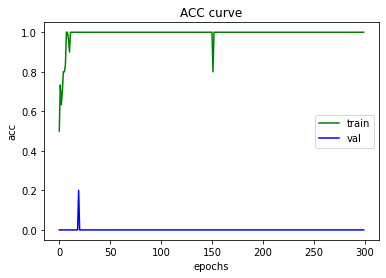

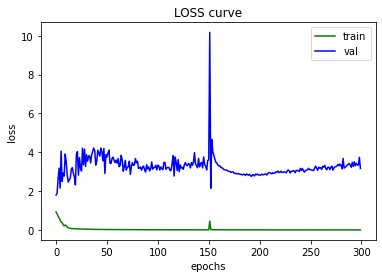

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.9322447694581131 1.4029978513717651
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.7784677589761799 1.6178536415100098
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.636127524848642 1.7419812440872193
acc : t/v 0.7241379310344828 0.0
loss: t/v 0.5664923815377827 1.5725196599960327
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.4179357086019269 2.6066440105438233
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.33878996428744546 2.0599730730056764
acc : t/v 1.0 0.0
loss: t/v 0.2646937055577492 2.1178329467773436
acc : t/v 0.9655172413793104 0.0
loss: t/v 0.21205876587793746 2.103169894218445
acc : t/v 0.9655172413793104 0.2
loss: t/v 0.2253466935764099 1.7312899351119995
acc : t/v 1.0 0.0
loss: t/v 0.12788349698329793 2.245755708217621
acc : t/v 1.0 0.4
loss: t/v 0.12689423985008536 1.7309075117111206
acc : t/v 1.0 0.2
loss: t/v 0.150924452548397 2.326038122177124
acc : t/v 1.0 0.0
loss: t/v 0.11623473850817516 2.62

KeyboardInterrupt: ignored

In [0]:
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/LOUO/'
nb_epochs = 300
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Suturing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name  
classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 
validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)
#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)

# model = load_model(path_to_results+'feedback/example-figure-in-paper/model.h5')

# encoder.classes_ = np.load(path_to_results+'feedback/example-figure-in-paper/binary_classes.npy')

# create_video_feedback(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004',slave_manipulator='_Left_mod')

# uncomment to visualize the trajectory illustrated in the paper
# class_activation_map(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004.pdf')

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

Number of different surgeries in total: 39
train size:30
val size:5
test size:4
4
5
drop out
acc : t/v 0.5 0.0
loss: t/v 0.9641296883424123 1.4927016019821167
acc : t/v 0.5 0.0
loss: t/v 0.8870000004768371 1.6283169269561768
acc : t/v 0.7 0.0
loss: t/v 0.7824634929498037 1.8648625612258911
acc : t/v 0.6333333333333333 0.0
loss: t/v 0.6975843206048011 2.0108782052993774
acc : t/v 0.8 0.0
loss: t/v 0.6223812960088253 1.9148686408996582
acc : t/v 0.8333333333333334 0.0
loss: t/v 0.5078234132379293 2.502639818191528
acc : t/v 0.9 0.0
loss: t/v 0.4120058229813973 2.445312476158142
acc : t/v 0.8 0.0
loss: t/v 0.4407267741858959 2.6322305679321287
acc : t/v 0.9 0.0
loss: t/v 0.3348313171416521 2.2744144916534426
acc : t/v 0.8333333333333334 0.0
loss: t/v 0.2943074217066169 2.398833751678467
acc : t/v 1.0 0.0
loss: t/v 0.19775296288232008 3.0284457445144652
acc : t/v 1.0 0.0
loss: t/v 0.14614938690016668 2.8838247060775757
acc : t/v 1.0 0.0
loss: t/v 0.12132190391421319 3.208743143081665
acc :

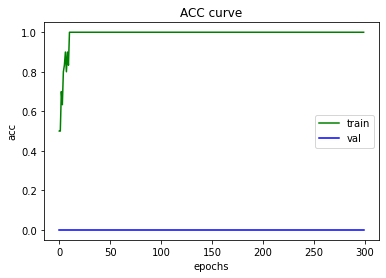

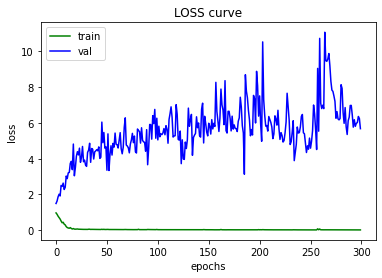

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
4
5
drop out
acc : t/v 0.7931034482758621 0.0
loss: t/v 1.0057393764627391 1.5013884544372558
acc : t/v 0.6206896551724138 0.0
loss: t/v 0.9123552297723705 1.87497718334198
acc : t/v 0.7241379310344828 0.0
loss: t/v 0.8249760670908566 1.9042274713516236
acc : t/v 0.7241379310344828 0.0
loss: t/v 0.7341967386932209 2.265459394454956
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.6406144462525845 2.151429796218872
acc : t/v 0.7586206896551724 0.0
loss: t/v 0.6835364717347868 1.6039657115936279
acc : t/v 0.7586206896551724 0.0
loss: t/v 0.5741215357235794 2.548866033554077
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.47649263115278606 1.6758870601654052
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.40032962549092443 1.8260231018066406
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.34847415039508506 2.217262601852417
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.33268275407367737 2.1192390441894533
acc : t/v 0.896551724137931 0.0
loss: t/v 0.2939239412160783 

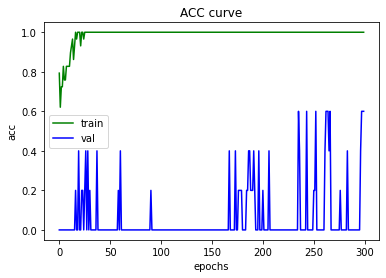

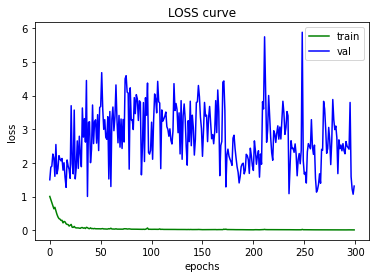

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
4
5
drop out
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.8909536291813028 2.0474955320358275
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.8545122886526173 2.12264666557312
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.7608785834805719 1.6854976654052733
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.653428390622139 1.809159278869629
acc : t/v 0.7241379310344828 0.0
loss: t/v 0.5845970863412167 1.7102760553359986
acc : t/v 0.6896551724137931 0.0
loss: t/v 0.4799152233734213 2.2275030851364135
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.3912994099845146 2.5858073949813845
acc : t/v 1.0 0.0
loss: t/v 0.3780580480293981 1.9570849657058715
acc : t/v 1.0 0.0
loss: t/v 0.28184233387482577 2.2799525260925293
acc : t/v 1.0 0.0
loss: t/v 0.2222885436795909 2.8703774929046633
acc : t/v 1.0 0.0
loss: t/v 0.18966359812124023 3.01589035987854
acc : t/v 1.0 0.0
loss: t/v 0.1810955262646593 3.0613643884658814
acc : t/v 0.9655172413793104 0.4
loss: t/v 0.281802847146

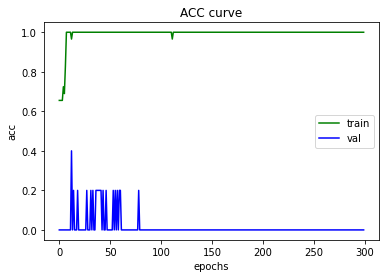

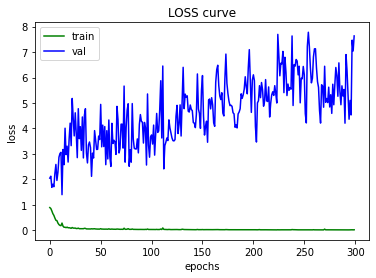

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
4
5
drop out
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.7913178041063506 2.7046719551086427
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.6196252107620239 3.925176239013672
acc : t/v 0.7586206896551724 0.0
loss: t/v 0.5387715630490204 4.767580795288086
acc : t/v 0.7586206896551724 0.0
loss: t/v 0.46400232022178584 5.862602996826172
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.36735601157977665 6.739985179901123
acc : t/v 1.0 0.0
loss: t/v 0.2666472832447496 6.4780323028564455
acc : t/v 0.9655172413793104 0.0
loss: t/v 0.22687780715782066 6.886806392669678
acc : t/v 1.0 0.0
loss: t/v 0.15175280135510297 6.2559388160705565
acc : t/v 1.0 0.0
loss: t/v 0.09359935902315995 7.096120452880859
acc : t/v 0.9655172413793104 0.0
loss: t/v 0.10976382434881966 7.612189292907715
acc : t/v 0.9655172413793104 0.0
loss: t/v 0.09984291486185172 8.715362071990967
acc : t/v 1.0 0.0
loss: t/v 0.08955589624057556 8.51504955291748
acc : t/v 1.0 0.0
loss: t/v 0.0442035965

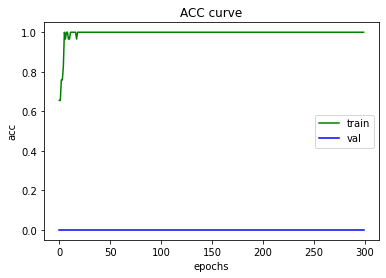

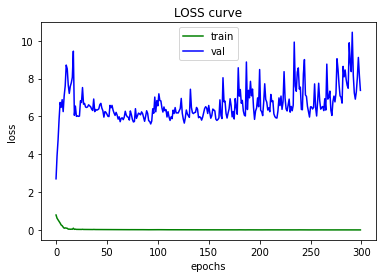

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
4
5
drop out
acc : t/v 0.4827586206896552 1.0
loss: t/v 1.0260362152395577 0.8412668824195861
acc : t/v 0.6551724137931034 1.0
loss: t/v 0.9249226985306576 0.8108371257781982
acc : t/v 0.6896551724137931 1.0
loss: t/v 0.8313064287448751 0.7136114597320556
acc : t/v 0.7241379310344828 1.0
loss: t/v 0.7428673978509575 0.6170038402080535
acc : t/v 0.6896551724137931 0.2
loss: t/v 0.7201632703172749 1.2459101676940918
acc : t/v 0.8620689655172413 0.6
loss: t/v 0.5753758184868714 0.6757781684398652
acc : t/v 0.8620689655172413 0.8
loss: t/v 0.49558442959497717 0.48661860823631287
acc : t/v 0.8620689655172413 0.8
loss: t/v 0.4354686162852008 0.4404419153928757
acc : t/v 1.0 1.0
loss: t/v 0.3871104658163827 0.3140240877866745
acc : t/v 0.8275862068965517 0.6
loss: t/v 0.38369498003659575 0.7490668952465057
acc : t/v 1.0 1.0
loss: t/v 0.2842909310912264 0.21009482741355895
acc : t/v 0.9310344827586207 0.8
loss: t/v 0.2407570816576481 0.3541104942560196
acc 

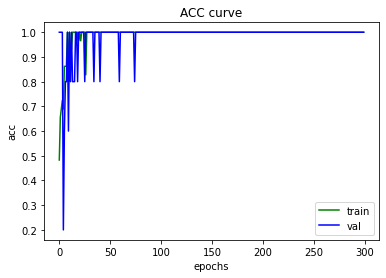

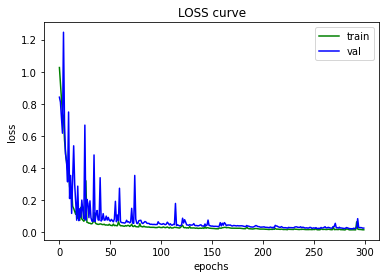

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
4
5
drop out
acc : t/v 0.4827586206896552 0.0
loss: t/v 1.0122993958407436 1.4228903293609618
acc : t/v 0.4827586206896552 0.0
loss: t/v 0.9531110710111158 1.9849102020263671
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.9276147875292547 1.6644397497177124
acc : t/v 0.5862068965517241 0.0
loss: t/v 0.8541083243386499 2.0739256143569946
acc : t/v 0.7931034482758621 0.0
loss: t/v 0.8157090914660486 1.9053157567977905
acc : t/v 0.7931034482758621 0.0
loss: t/v 0.7205365855118324 2.281410813331604
acc : t/v 0.7586206896551724 0.0
loss: t/v 0.641064610974542 2.111910033226013
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.49582770723721076 2.6008543968200684
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.42214227955916833 2.243700957298279
acc : t/v 0.896551724137931 0.0
loss: t/v 0.34103191823794926 2.048498106002808
acc : t/v 0.9655172413793104 0.0
loss: t/v 0.26699229072907876 2.7804423809051513
acc : t/v 1.0 0.0
loss: t/v 0.22058185678103875 2.63746144771

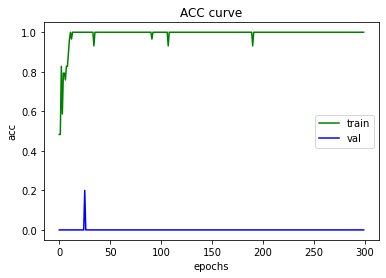

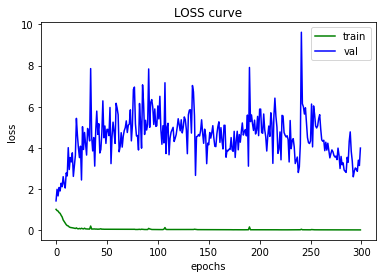

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
4
5
drop out
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.7942091627367611 2.1872315883636473
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.74456426809574 3.2083622932434084
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.6161835355491474 2.3180388450622558
acc : t/v 0.6551724137931034 0.0
loss: t/v 0.5582416043456259 2.3542439937591553
acc : t/v 0.7241379310344828 0.0
loss: t/v 0.4888182133436203 2.857301950454712
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.4611028115554103 2.46177453994751
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.38485107622269926 3.7824057579040526
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.31734277089608126 3.8397673606872558
acc : t/v 0.9310344827586207 0.0
loss: t/v 0.302366824499492 4.869441032409668
acc : t/v 0.9655172413793104 0.0
loss: t/v 0.2265480287886899 4.320314264297485
acc : t/v 0.7931034482758621 0.0
loss: t/v 0.3222677832276657 4.706134271621704
acc : t/v 0.9655172413793104 0.0
loss: t/v 0.22407363361582674 4.7

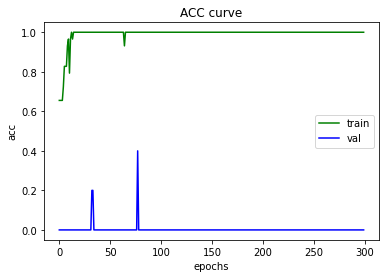

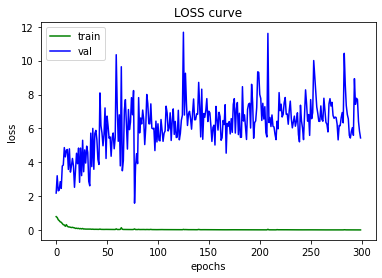

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:5
test size:5
4
5
drop out
acc : t/v 0.4827586206896552 0.0
loss: t/v 1.0258104575091396 1.306940460205078
acc : t/v 0.4827586206896552 0.0
loss: t/v 0.9047388218600174 1.6607591390609742
acc : t/v 0.4827586206896552 0.0
loss: t/v 0.9221564634092922 1.564928364753723
acc : t/v 0.6896551724137931 0.0
loss: t/v 0.7480255545213305 1.9200367212295533
acc : t/v 0.6896551724137931 0.0
loss: t/v 0.6553783177815634 2.0728318214416506
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.5513548012180575 1.7075623273849487
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.4258906960101991 2.3899810314178467
acc : t/v 0.9310344827586207 0.0
loss: t/v 0.3826675332183468 2.3037291049957274
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.34465217166419687 3.3966880798339845
acc : t/v 0.9310344827586207 0.0
loss: t/v 0.29135319667643517 2.3021201133728026
acc : t/v 1.0 0.0
loss: t/v 0.23971030848293468 3.04220871925354
acc : t/v 0.8275862068965517 0.0
loss: t/v 0.39104717533136235 4.1867533206

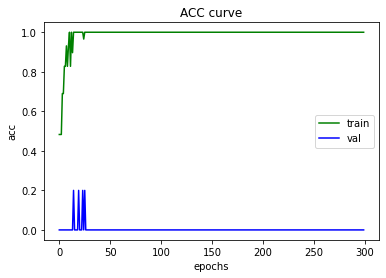

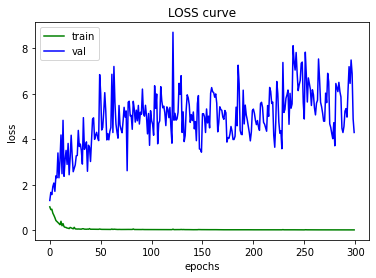

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

      N    I    E
N  19.0  5.0  3.0
I   0.0  0.0  5.0
E   0.0  5.0  2.0
--- 6440.946198225021 seconds ---
End!


In [0]:
#time Drop out
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/LOUO/'
nb_epochs = 300
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Suturing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name  
classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 
validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)
#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)

# model = load_model(path_to_results+'feedback/example-figure-in-paper/model.h5')

# encoder.classes_ = np.load(path_to_results+'feedback/example-figure-in-paper/binary_classes.npy')

# create_video_feedback(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004',slave_manipulator='_Left_mod')

# uncomment to visualize the trajectory illustrated in the paper
# class_activation_map(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004.pdf')

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: loadtxt: Empty input file: "/content/drive/My Drive/Colab Notebooks/SDSProject/MyProject/Data/jigsaws/Knot_Tying/kinematics/AllGestures/Knot_Tying_H002.txt"


Number of different surgeries in total: 36
train size:26
val size:5
test size:5
acc : t/v 0.4230769230769231 0.0
loss: t/v 0.9241080307043515 1.6376952171325683
acc : t/v 0.6153846153846154 0.0
loss: t/v 0.8058754371908995 1.6670778751373292
acc : t/v 0.6538461538461539 0.0
loss: t/v 0.7354069154423016 1.9003390550613404
acc : t/v 0.6538461538461539 0.0
loss: t/v 0.6993999479768368 1.8192760229110718
acc : t/v 0.6923076923076923 0.0
loss: t/v 0.6736943314138514 1.739272665977478
acc : t/v 0.7307692307692307 0.0
loss: t/v 0.6230278800313289 2.000352215766907
acc : t/v 0.8076923076923077 0.0
loss: t/v 0.5989226214587688 1.8879497289657592
acc : t/v 0.7307692307692307 0.0
loss: t/v 0.5335484661448461 2.194682002067566
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.5312426552319756 1.8924558877944946
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.4766853079916193 2.3457224130630494
acc : t/v 0.6923076923076923 0.0
loss: t/v 0.5287562878802419 2.824378776550293
acc : t/v 0.9615384615384616 0.0


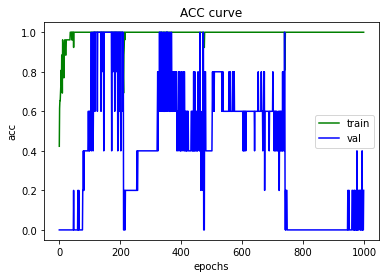

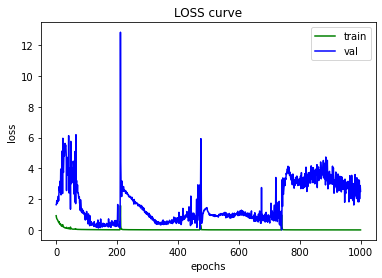

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.8461538461538461 0.0
loss: t/v 0.614687626178448 3.1608702182769775
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.4535243267623278 4.676675319671631
acc : t/v 0.9230769230769231 0.0
loss: t/v 0.37578144382971984 5.7181620597839355
acc : t/v 0.8076923076923077 0.0
loss: t/v 0.41705919644580436 7.18139066696167
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.301259170859479 7.026843738555908
acc : t/v 0.8076923076923077 0.0
loss: t/v 0.2853927102942879 8.033378982543946
acc : t/v 0.9230769230769231 0.0
loss: t/v 0.26501185468469673 6.873992919921875
acc : t/v 0.9230769230769231 0.0
loss: t/v 0.22677229932294443 7.493087673187256
acc : t/v 0.9615384615384616 0.0
loss: t/v 0.21301596489949867 7.832479190826416
acc : t/v 0.8461538461538461 0.0
loss: t/v 0.351162350235077 9.58516902923584
acc : t/v 0.9230769230769231 0.0
loss: t/v 0.27539795379226023 6.02171516418457
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.21444584701496822 7.77175931930542
a

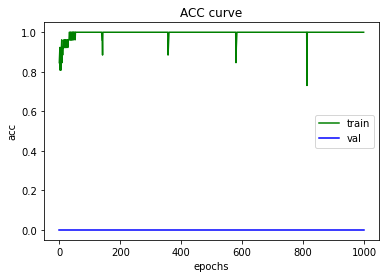

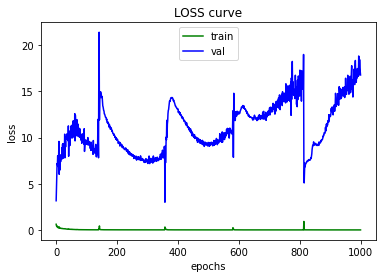

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.6153846153846154 0.0
loss: t/v 0.8562369392468379 1.3644176483154298
acc : t/v 0.6153846153846154 0.0
loss: t/v 0.7863758550240443 1.487821841239929
acc : t/v 0.6538461538461539 0.0
loss: t/v 0.7102655602189211 1.2817343711853026
acc : t/v 0.6923076923076923 0.0
loss: t/v 0.6505167912691832 1.256031370162964
acc : t/v 0.7307692307692307 0.0
loss: t/v 0.6116405062807294 1.1422165870666503
acc : t/v 0.8076923076923077 0.0
loss: t/v 0.5600764641108421 1.373625349998474
acc : t/v 0.6923076923076923 0.0
loss: t/v 0.5614353416917416 1.3676615715026856
acc : t/v 0.8076923076923077 0.0
loss: t/v 0.47645792880883586 1.4029959678649901
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.4687660906750422 1.25420241355896
acc : t/v 0.9230769230769231 0.0
loss: t/v 0.3954756806532924 1.44445960521698
acc : t/v 0.7692307692307693 0.2
loss: t/v 0.45063232709295475 1.2292839288711548
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.35349404023816955 2.181809020042

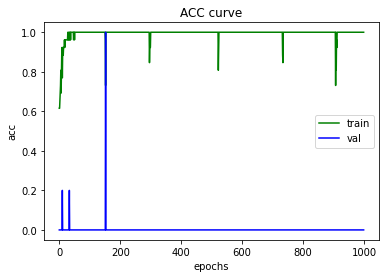

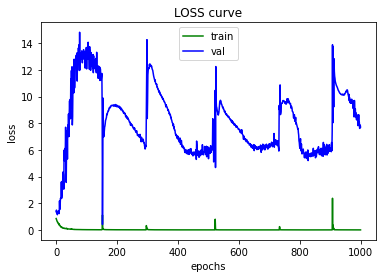

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.6153846153846154 0.0
loss: t/v 0.8150061689890348 1.3163049936294555
acc : t/v 0.6538461538461539 0.0
loss: t/v 0.6533109220461204 1.1420153379440308
acc : t/v 0.8076923076923077 0.0
loss: t/v 0.5925117135047913 1.0696385145187377
acc : t/v 0.7307692307692307 0.0
loss: t/v 0.538768069102214 1.2401274919509888
acc : t/v 0.8461538461538461 0.0
loss: t/v 0.43758687885621417 1.1931958436965941
acc : t/v 0.9230769230769231 0.0
loss: t/v 0.3189383517377652 1.078430986404419
acc : t/v 0.9615384615384616 0.2
loss: t/v 0.26105491107759565 1.054848039150238
acc : t/v 1.0 0.4
loss: t/v 0.21886887186421797 0.8567065954208374
acc : t/v 0.9615384615384616 0.2
loss: t/v 0.1853210596510997 1.2009280681610108
acc : t/v 1.0 0.4
loss: t/v 0.14493235480040312 1.0052067041397095
acc : t/v 0.9615384615384616 0.6
loss: t/v 0.14553191161786133 0.835796844959259
acc : t/v 1.0 0.0
loss: t/v 0.12955116774313724 1.3716426610946655
acc : t/v 1.0 0.8
loss: t/v 0.1221

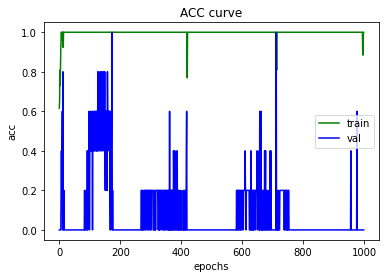

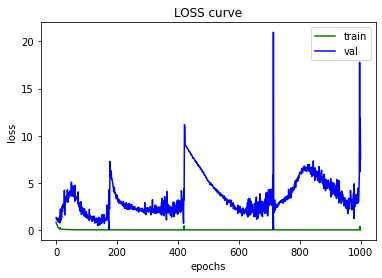

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.6153846153846154 0.0
loss: t/v 0.8891815004440454 1.7741570711135863
acc : t/v 0.6153846153846154 0.0
loss: t/v 0.7692384716983025 1.2941179275512695
acc : t/v 0.6538461538461539 0.6
loss: t/v 0.6929149622670733 1.0522419691085816
acc : t/v 0.7692307692307693 0.0
loss: t/v 0.6262964237696276 1.1281153917312623
acc : t/v 0.6538461538461539 0.0
loss: t/v 0.5936975772492588 1.3649797439575195
acc : t/v 0.8076923076923077 0.0
loss: t/v 0.5447050065805132 1.1639942884445191
acc : t/v 0.7692307692307693 1.0
loss: t/v 0.5638810835348872 0.6405941247940063
acc : t/v 0.8076923076923077 0.4
loss: t/v 0.4908581133931875 0.9542447924613953
acc : t/v 0.8461538461538461 0.0
loss: t/v 0.4303898092072744 1.1651455163955688
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.40807877459491676 0.3080308198928833
acc : t/v 0.8461538461538461 0.0
loss: t/v 0.38000115723564076 2.0014435768127443
acc : t/v 0.8846153846153846 0.0
loss: t/v 0.35923948941322476 1.48677

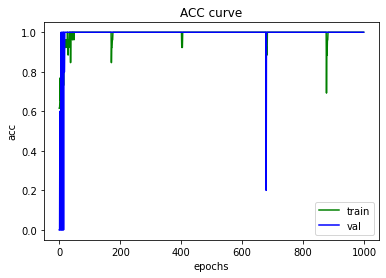

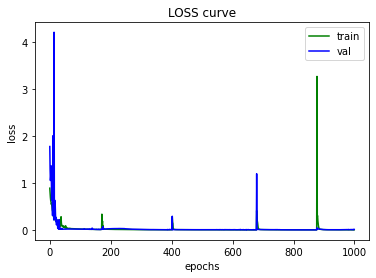

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:5
test size:4
acc : t/v 0.6296296296296297 0.0
loss: t/v 0.9972749904349998 1.4524665355682373
acc : t/v 0.5925925925925926 0.0
loss: t/v 0.9059844590999462 1.4287140130996705
acc : t/v 0.7037037037037037 0.0
loss: t/v 0.8331848438139315 1.6388499975204467
acc : t/v 0.7037037037037037 0.0
loss: t/v 0.7600935145660683 1.5029690980911254
acc : t/v 0.7037037037037037 0.0
loss: t/v 0.69961092731467 1.6714436292648316
acc : t/v 0.7037037037037037 0.0
loss: t/v 0.7257165126502514 2.174337291717529
acc : t/v 0.7037037037037037 0.0
loss: t/v 0.6643993517866841 1.868841528892517
acc : t/v 0.7777777777777778 0.0
loss: t/v 0.5727725411178889 2.156258296966553
acc : t/v 0.7407407407407407 0.0
loss: t/v 0.5281305249642443 3.319814443588257
acc : t/v 0.8888888888888888 0.0
loss: t/v 0.4859893036385377 1.9134662628173829
acc : t/v 0.8148148148148148 0.0
loss: t/v 0.42652554133975945 3.1434017181396485
acc : t/v 0.9629629629629629 0.0
loss: t/v 0.3626543599422331 2.8040400028228

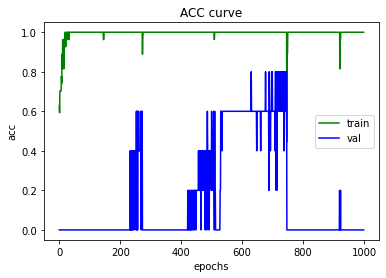

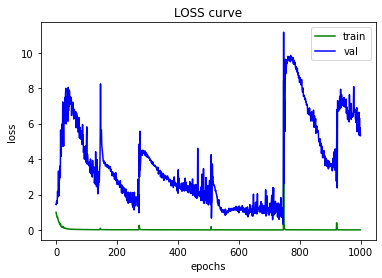

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:28
val size:5
test size:3
acc : t/v 0.75 0.0
loss: t/v 0.7503721083381346 1.4059675455093383
acc : t/v 0.75 0.0
loss: t/v 0.61903066188097 1.423160433769226
acc : t/v 0.7142857142857143 0.0
loss: t/v 0.5521258918701538 1.9046343326568604
acc : t/v 0.75 0.0
loss: t/v 0.5163228527775833 1.3938766241073608
acc : t/v 0.7857142857142857 0.0
loss: t/v 0.4670278683437833 1.4984960317611695
acc : t/v 0.7857142857142857 0.0
loss: t/v 0.4217698302652155 2.0425755977630615
acc : t/v 0.7857142857142857 0.0
loss: t/v 0.41639310580545236 2.080625033378601
acc : t/v 0.7857142857142857 0.0
loss: t/v 0.37410092420343843 2.323674201965332
acc : t/v 0.9285714285714286 0.0
loss: t/v 0.3583849661185273 1.668412709236145
acc : t/v 0.7857142857142857 0.0
loss: t/v 0.36087075368102106 2.5584133148193358
acc : t/v 0.9642857142857143 0.0
loss: t/v 0.27236382769686834 2.1522556066513063
acc : t/v 0.9642857142857143 0.0
loss: t/v 0.250413845492793 2.5356494665145872
acc : t/v 0.9285714285714286 0.0
los

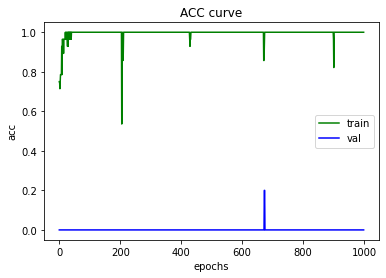

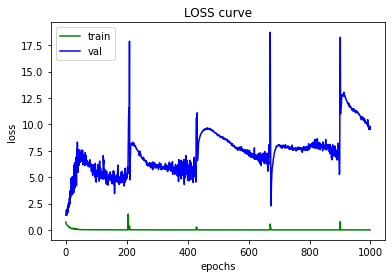

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:5
test size:4
acc : t/v 0.4444444444444444 0.0
loss: t/v 1.0006117931118719 1.4723690509796143
acc : t/v 0.7777777777777778 0.0
loss: t/v 0.8647963763387115 1.5119787931442261
acc : t/v 0.7037037037037037 0.0
loss: t/v 0.7225498179042781 1.5382858514785767
acc : t/v 0.7407407407407407 0.0
loss: t/v 0.6316391464184832 1.4221359014511108
acc : t/v 0.7037037037037037 0.0
loss: t/v 0.5671726244467276 1.8721003532409668
acc : t/v 0.7407407407407407 0.0
loss: t/v 0.5096345048535753 1.9903872966766358
acc : t/v 0.8148148148148148 0.0
loss: t/v 0.4783328756414078 2.17844877243042
acc : t/v 0.8148148148148148 0.0
loss: t/v 0.42766144023173386 2.1024070978164673
acc : t/v 0.8148148148148148 0.0
loss: t/v 0.38024126552045345 3.0671107292175295
acc : t/v 1.0 0.0
loss: t/v 0.3217517017490334 2.7565395832061768
acc : t/v 0.8518518518518519 0.0
loss: t/v 0.3359544760099164 4.439450454711914
acc : t/v 0.8518518518518519 0.0
loss: t/v 0.4347910737549817 1.6909664869308472
acc : t

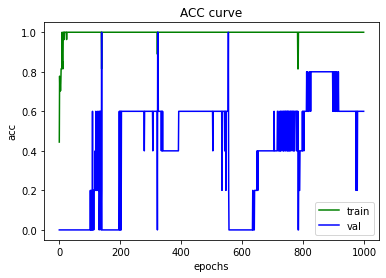

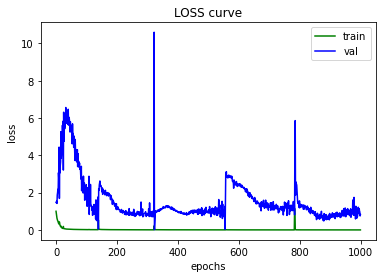

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

      N    I    E
N  13.0  5.0  2.0
I   3.0  0.0  8.0
E   0.0  5.0  0.0
--- 16375.963000059128 seconds ---
End!


In [6]:
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/LOUO/'
nb_epochs = 1000
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Knot_Tying'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name  
classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 
validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)
#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)

# model = load_model(path_to_results+'feedback/example-figure-in-paper/model.h5')

# encoder.classes_ = np.load(path_to_results+'feedback/example-figure-in-paper/binary_classes.npy')

# create_video_feedback(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004',slave_manipulator='_Left_mod')

# uncomment to visualize the trajectory illustrated in the paper
# class_activation_map(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004.pdf')

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

In [0]:
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/LOUO/'
nb_epochs = 300
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Needle_Passing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name  
classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 
validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)
#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)

# model = load_model(path_to_results+'feedback/example-figure-in-paper/model.h5')

# encoder.classes_ = np.load(path_to_results+'feedback/example-figure-in-paper/binary_classes.npy')

# create_video_feedback(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004',slave_manipulator='_Left_mod')

# uncomment to visualize the trajectory illustrated in the paper
# class_activation_map(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004.pdf')

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")